In [2]:
from datasets.shapenet_part import PartNormalDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np


from modules.se import SE3d
from modules.ball_query import BallQuery
from modules.shared_mlp import SharedMLP
from modules.voxelization import Voxelization
import modules.functional as F

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud


In [3]:
tr_dataset = PartNormalDataset(root="shapenetcore_partanno_segmentation_benchmark_v0_normal",
                            class_choice=["Airplane"],
                            split="train")

val_dataset = PartNormalDataset(root="shapenetcore_partanno_segmentation_benchmark_v0_normal",
                            class_choice=["Airplane"],
                            split="val")

test_dataset = PartNormalDataset(root="shapenetcore_partanno_segmentation_benchmark_v0_normal",
                            class_choice=["Airplane"],
                            split="val")

{'Airplane': '02691156'}
{'Airplane': '02691156'}
{'Airplane': '02691156'}


In [4]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(1958, 391, 391)

In [5]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=50, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=50, 
                                               num_workers=1, 
                                               drop_last=True)

In [6]:
class PointNetAModule(nn.Module):
    def __init__(self, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]]
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels]

        mlps = []
        total_out_channels = 0
        for _out_channels in out_channels:
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=1)
            )
            total_out_channels += _out_channels[-1]

        self.include_coordinates = include_coordinates
        self.out_channels = total_out_channels
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        if self.include_coordinates:
            features = torch.cat([features, coords], dim=1)
        coords = torch.zeros((coords.size(0), 3, 1), device=coords.device)
        if len(self.mlps) > 1:
            features_list = []
            for mlp in self.mlps:
                features_list.append(mlp(features).max(dim=-1, keepdim=True).values)
            return torch.cat(features_list, dim=1), coords
        else:
            return self.mlps[0](features).max(dim=-1, keepdim=True).values, coords

    def extra_repr(self):
        return f'out_channels={self.out_channels}, include_coordinates={self.include_coordinates}'


class PointNetSAModule(nn.Module):
    def __init__(self, num_centers, radius, num_neighbors, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(radius, (list, tuple)):
            radius = [radius]
        if not isinstance(num_neighbors, (list, tuple)):
            num_neighbors = [num_neighbors] * len(radius)
        assert len(radius) == len(num_neighbors)
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]] * len(radius)
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels] * len(radius)
        assert len(radius) == len(out_channels)

        groupers, mlps = [], []
        total_out_channels = 0
        for _radius, _out_channels, _num_neighbors in zip(radius, out_channels, num_neighbors):
            groupers.append(
                BallQuery(radius=_radius, num_neighbors=_num_neighbors, include_coordinates=include_coordinates)
            )
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=2)
            )
            total_out_channels += _out_channels[-1]

        self.num_centers = num_centers
        self.out_channels = total_out_channels
        self.groupers = nn.ModuleList(groupers)
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        centers_coords = F.furthest_point_sample(coords, self.num_centers)
        features_list = []
        for grouper, mlp in zip(self.groupers, self.mlps):
            features_list.append(mlp(grouper(coords, centers_coords, features)).max(dim=-1).values)
        if len(features_list) > 1:
            return torch.cat(features_list, dim=1), centers_coords
        else:
            return features_list[0], centers_coords

    def extra_repr(self):
        return f'num_centers={self.num_centers}, out_channels={self.out_channels}'


class PointNetFPModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = SharedMLP(in_channels=in_channels, out_channels=out_channels, dim=1)

    def forward(self, inputs):
        if len(inputs) == 3:
            points_coords, centers_coords, centers_features = inputs
            points_features = None
        else:
            points_coords, centers_coords, centers_features, points_features = inputs
        interpolated_features = F.nearest_neighbor_interpolate(points_coords, centers_coords, centers_features)
        if points_features is not None:
            interpolated_features = torch.cat(
                [interpolated_features, points_features], dim=1
            )
        return self.mlp(interpolated_features), points_coords

In [7]:
class PVConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, resolution, with_se=False, normalize=True, eps=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.resolution = resolution

        self.voxelization = Voxelization(resolution, normalize=normalize, eps=eps)
        voxel_layers = [
            nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
            nn.Conv3d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
         ]
        if with_se:
            voxel_layers.append(SE3d(out_channels))
        self.voxel_layers = nn.Sequential(*voxel_layers)
        self.point_features = SharedMLP(in_channels, out_channels)

    def forward(self, inputs):
        features, coords = inputs
        voxel_features, voxel_coords = self.voxelization(features, coords)
        voxel_features = self.voxel_layers(voxel_features)
        voxel_features = F.trilinear_devoxelize(voxel_features, voxel_coords, self.resolution, self.training)
        fused_features = voxel_features + self.point_features(features)
        return fused_features, coords

In [8]:
def _linear_bn_relu(in_channels, out_channels):
    return nn.Sequential(nn.Linear(in_channels, out_channels), nn.BatchNorm1d(out_channels), nn.ReLU(True))


def create_mlp_components(in_channels, out_channels, classifier=False, dim=2, width_multiplier=1):
    r = width_multiplier

    if dim == 1:
        block = _linear_bn_relu
    else:
        block = SharedMLP
    if not isinstance(out_channels, (list, tuple)):
        out_channels = [out_channels]
    if len(out_channels) == 0 or (len(out_channels) == 1 and out_channels[0] is None):
        return nn.Sequential(), in_channels, in_channels

    layers = []
    for oc in out_channels[:-1]:
        if oc < 1:
            layers.append(nn.Dropout(oc))
        else:
            oc = int(r * oc)
            layers.append(block(in_channels, oc))
            in_channels = oc
    if dim == 1:
        if classifier:
            layers.append(nn.Linear(in_channels, out_channels[-1]))
        else:
            layers.append(_linear_bn_relu(in_channels, int(r * out_channels[-1])))
    else:
        if classifier:
            layers.append(nn.Conv1d(in_channels, out_channels[-1], 1))
        else:
            layers.append(SharedMLP(in_channels, int(r * out_channels[-1])))
    return layers, out_channels[-1] if classifier else int(r * out_channels[-1])


def create_pointnet_components(blocks, in_channels, with_se=False, normalize=True, eps=0,
                               width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    layers, concat_channels = [], 0
    for out_channels, num_blocks, voxel_resolution in blocks:
        out_channels = int(r * out_channels)
        if voxel_resolution is None:
            block = SharedMLP
        else:
            block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                      with_se=with_se, normalize=normalize, eps=eps)
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels))
            in_channels = out_channels
            concat_channels += out_channels
    return layers, in_channels, concat_channels


def create_pointnet2_sa_components(sa_blocks, extra_feature_channels, with_se=False, normalize=True, eps=0,
                                   width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier
    in_channels = extra_feature_channels + 3

    sa_layers, sa_in_channels = [], []
    for conv_configs, sa_configs in sa_blocks:
        sa_in_channels.append(in_channels)
        sa_blocks = []
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                sa_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
            extra_feature_channels = in_channels
        num_centers, radius, num_neighbors, out_channels = sa_configs
        _out_channels = []
        for oc in out_channels:
            if isinstance(oc, (list, tuple)):
                _out_channels.append([int(r * _oc) for _oc in oc])
            else:
                _out_channels.append(int(r * oc))
        out_channels = _out_channels
        if num_centers is None:
            block = PointNetAModule
        else:
            block = functools.partial(PointNetSAModule, num_centers=num_centers, radius=radius,
                                      num_neighbors=num_neighbors)
        sa_blocks.append(block(in_channels=extra_feature_channels, out_channels=out_channels,
                               include_coordinates=True))
        in_channels = extra_feature_channels = sa_blocks[-1].out_channels
        if len(sa_blocks) == 1:
            sa_layers.append(sa_blocks[0])
        else:
            sa_layers.append(nn.Sequential(*sa_blocks))

    return sa_layers, sa_in_channels, in_channels, 1 if num_centers is None else num_centers


def create_pointnet2_fp_modules(fp_blocks, in_channels, sa_in_channels, with_se=False, normalize=True, eps=0,
                                width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    fp_layers = []
    for fp_idx, (fp_configs, conv_configs) in enumerate(fp_blocks):
        fp_blocks = []
        out_channels = tuple(int(r * oc) for oc in fp_configs)
        fp_blocks.append(
            PointNetFPModule(in_channels=in_channels + sa_in_channels[-1 - fp_idx], out_channels=out_channels)
        )
        in_channels = out_channels[-1]
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                fp_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
        if len(fp_blocks) == 1:
            fp_layers.append(fp_blocks[0])
        else:
            fp_layers.append(nn.Sequential(*fp_blocks))

    return fp_layers, in_channels

In [9]:
class PVCNN(nn.Module):
    blocks = ((64, 1, 32), (128, 2, 16), (512, 1, None), (2048, 1, None))

    def __init__(self, num_classes, num_shapes, extra_feature_channels=3,
                 width_multiplier=1, voxel_resolution_multiplier=1):
        super().__init__()
        assert extra_feature_channels >= 0
        self.in_channels = extra_feature_channels + 3
        self.num_shapes = num_shapes

        layers, channels_point, concat_channels_point = create_pointnet_components(
            blocks=self.blocks, in_channels=self.in_channels, with_se=True, normalize=False,
            width_multiplier=width_multiplier, voxel_resolution_multiplier=voxel_resolution_multiplier
        )
        self.point_features = nn.ModuleList(layers)

        layers, _ = create_mlp_components(in_channels=(num_shapes + channels_point + concat_channels_point),
                                          out_channels=[256, 0.2, 256, 0.2, 128, num_classes],
                                          classifier=True, dim=2, width_multiplier=width_multiplier)
        self.classifier = nn.Sequential(*layers)

    def forward(self, inputs):
        # inputs : [B, in_channels + S, N]
        features = inputs[:, :self.in_channels, :]
        one_hot_vectors = inputs[:, -self.num_shapes:, :]
        num_points = features.size(-1)

        coords = features[:, :3, :]
        out_features_list = [one_hot_vectors]
        for i in range(len(self.point_features)):
            features, _ = self.point_features[i]((features, coords))
            out_features_list.append(features)
        out_features_list.append(features.max(dim=-1, keepdim=True).values.repeat([1, 1, num_points]))
        
        logits = self.classifier(torch.cat(out_features_list, dim=1))

        return torch.nn.functional.softmax(logits, dim=1) 

In [10]:
# Airplane has 4 part classes

model = PVCNN(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")

In [16]:
# Check if it all works

criterion = nn.CrossEntropyLoss()
num_part = 4

for (point_set, cls, seg) in train_dataloader:
    print(point_set.shape, cls.shape, seg.shape)

    output = model(point_set.to("cuda").transpose(1,2)).transpose(1,2)

    print(output.shape)
    seg = seg.to("cuda").long()

    output = output.reshape(-1, num_part)
    seg = seg.flatten()

    print(output.shape, seg.shape)

    # Measure the Cross Entropy Loss
    loss = criterion(output, seg)
    print(f"Loss: {loss.item():.4f}")

    # Measure the Accuracy
    

    break

torch.Size([20, 2048, 3]) torch.Size([20, 1]) torch.Size([20, 2048])
torch.Size([20, 2048, 4])
torch.Size([40960, 4]) torch.Size([40960])
Loss: 1.4051


In [20]:
print(f"Test: {(output.data.max(1)[1].eq(seg).sum() / seg.shape[0]) * 100:.4f}%")

Test: 20.5786%


In [26]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Part-Segmentation'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Loss function
num_part = 4
criterion = nn.CrossEntropyLoss()

# Optimization
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Accuracies
train_accuracies = []
val_accuracies = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    total_train_acc = 0
    total_val_acc = 0

    # Train
    model.train()
    for (point_set, _, seg) in train_dataloader:
        point_set = point_set.to("cuda").transpose(1,2)
                
        optimizer.zero_grad()

        output = model(point_set).transpose(1,2)
        output = output.reshape(-1, num_part)

        seg = seg.to("cuda").long()
        seg = seg.flatten()


        loss = criterion(output, seg)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += output.data.max(1)[1].eq(seg).sum() / seg.shape[0]

    # Training epoch done => Step for the LR Scheduler
    lr_scheduler.step()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    epoch_train_acc = total_train_acc / len(train_dataloader)
    train_accuracies.append(epoch_train_acc)

    # Validate
    model.eval()
    with torch.no_grad():
        for (point_set, _, seg) in val_dataloader:
            point_set = point_set.to("cuda").transpose(1,2)

            output = model(point_set).transpose(1,2)
            output = output.reshape(-1, num_part)

            seg = seg.to("cuda").long()
            seg = seg.flatten()

            val_loss = criterion(output, seg)
            total_val_loss += val_loss.item()
            total_val_acc += output.data.max(1)[1].eq(seg).sum() / seg.shape[0]

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    epoch_val_acc = total_val_acc / len(val_dataloader)
    val_accuracies.append(epoch_val_acc)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    writer.add_scalar('Acc/train', epoch_train_acc * 100, epoch)
    writer.add_scalar('Acc/val', epoch_val_acc * 100, epoch)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {epoch_train_acc * 100:.4f}%, Val Acc: {epoch_val_acc * 100:.4f}%")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-part-segmentation/PVCNN-Part-Segmentation-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)

writer.close()

Epoch 1 | Train Loss: 0.8006, Val Loss: 0.7961, Train Acc: 94.2427%, Val Acc: 94.6953%
Epoch 2 | Train Loss: 0.8007, Val Loss: 0.7954, Train Acc: 94.2324%, Val Acc: 94.7633%
Epoch 3 | Train Loss: 0.7993, Val Loss: 0.7961, Train Acc: 94.3723%, Val Acc: 94.6946%
No improvement in validation loss for 1 epochs.
Epoch 4 | Train Loss: 0.7999, Val Loss: 0.7959, Train Acc: 94.3136%, Val Acc: 94.6969%
No improvement in validation loss for 2 epochs.
Epoch 5 | Train Loss: 0.7994, Val Loss: 0.7980, Train Acc: 94.3671%, Val Acc: 94.5043%
No improvement in validation loss for 3 epochs.
Epoch 6 | Train Loss: 0.7993, Val Loss: 0.7970, Train Acc: 94.3706%, Val Acc: 94.5967%
No improvement in validation loss for 4 epochs.
Epoch 7 | Train Loss: 0.7977, Val Loss: 0.7956, Train Acc: 94.5331%, Val Acc: 94.7372%
No improvement in validation loss for 5 epochs.
Epoch 8 | Train Loss: 0.7978, Val Loss: 0.7978, Train Acc: 94.5313%, Val Acc: 94.5148%
No improvement in validation loss for 6 epochs.
Epoch 9 | Train 

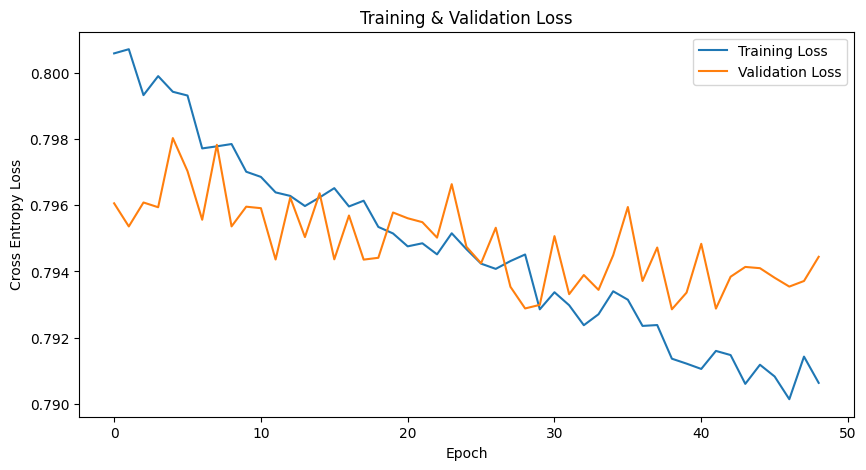

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

In [31]:
for i in range(len(train_accuracies)):
    train_accuracies[i] = train_accuracies[i].cpu()
    val_accuracies[i] = val_accuracies[i].cpu()

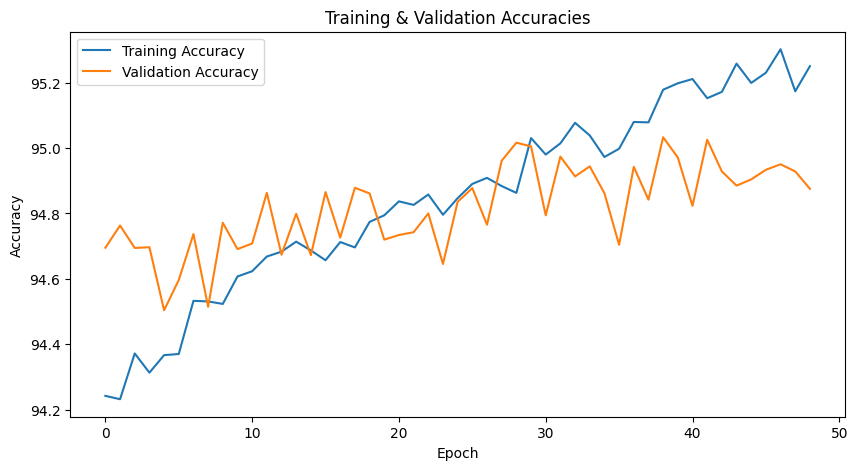

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_accuracies) * 100, label='Training Accuracy')
plt.plot(np.array(val_accuracies) * 100, label='Validation Accuracy')
plt.title('Training & Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
print(f"Best Train Acc: Epoch: {np.argmax(train_accuracies)}, Acc: {np.max(train_accuracies) * 100:.4f}")
print(f"Best Val Acc: Epoch: {np.argmax(val_accuracies)}, Acc: {np.max(val_accuracies) * 100:.4f}")

Best Train Acc: Epoch: 46, Acc: 95.3019
Best Val Acc: Epoch: 38, Acc: 95.0329


In [37]:
print(f"Best Train Loss: Epoch: {np.argmin(training_losses)}, Acc: {np.min(training_losses) * 100:.4f}")
print(f"Best Val Loss: Epoch: {np.argmin(val_losses)}, Acc: {np.min(val_losses) * 100:.4f}")

Best Train Loss: Epoch: 46, Acc: 79.0146
Best Val Loss: Epoch: 38, Acc: 79.2859


In [38]:
model = PVCNN(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load(f"output-models/pvcnn-part-segmentation/PVCNN-Part-Segmentation-e{np.argmax(val_losses)+1}.pth"))

<All keys matched successfully>

In [40]:
model.eval()

total_test_loss = 0
total_test_acc = 0
i = 1

with torch.no_grad():  
     for (point_set, _, seg) in test_dataloader:
        point_set = point_set.to("cuda").transpose(1,2)

        output = model(point_set).transpose(1,2)
        output = output.reshape(-1, num_part)

        seg = seg.to("cuda").long()
        seg = seg.flatten()

        test_loss = criterion(output, seg)

        total_test_loss += test_loss.item()
        batch_acc = output.data.max(1)[1].eq(seg).sum() / seg.shape[0]
        total_test_acc += batch_acc

        print(f"Batch {i}, CE Loss: {loss.item():.4f}, Accuracy: {batch_acc * 100:.4f}%")
        i+=1

avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_acc = total_test_acc / len(test_dataloader)
print(f"Test CE Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc * 100:.4f}%")

Batch 1, CE Loss: 0.7887, Accuracy: 94.5986%
Batch 2, CE Loss: 0.7887, Accuracy: 94.1973%
Batch 3, CE Loss: 0.7887, Accuracy: 94.5937%
Batch 4, CE Loss: 0.7887, Accuracy: 94.8604%
Batch 5, CE Loss: 0.7887, Accuracy: 94.9033%
Batch 6, CE Loss: 0.7887, Accuracy: 94.3076%
Batch 7, CE Loss: 0.7887, Accuracy: 94.3643%
Test CE Loss: 0.7976, Test Accuracy: 94.5465%


In [41]:
with torch.no_grad():  
     for (point_set, _, seg) in test_dataloader:
        point_set = point_set.to("cuda").transpose(1,2)
        output = model(point_set).transpose(1,2)
        break

In [48]:
output_parts = output.data.max(2)[1]
output_parts.shape

torch.Size([50, 2048])

In [51]:
output_pc = point_set.transpose(1,2)
output_pc.shape

torch.Size([50, 2048, 3])

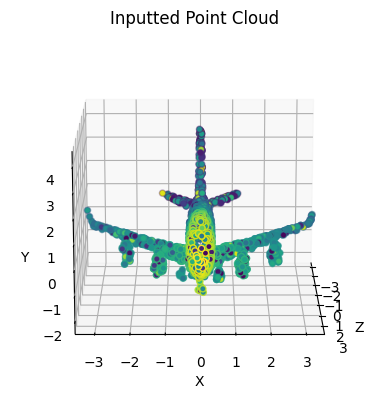

In [74]:
input_np = output_pc[43,...].squeeze().detach().cpu().numpy()
pc = rotate_point_cloud_y(input_np, 90)
pc = rotate_point_cloud_x(pc, -90)
pc = rotate_point_cloud_x(pc, 90)
fig = visualize_pointcloud(pc, f"Inputted Point Cloud")

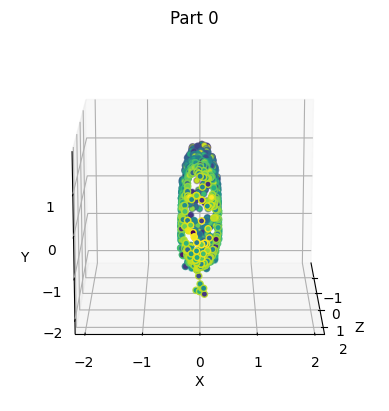

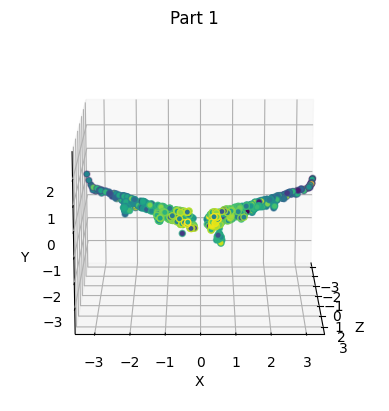

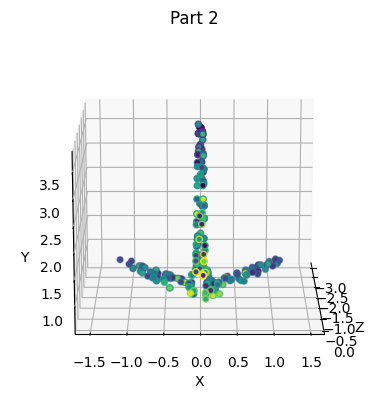

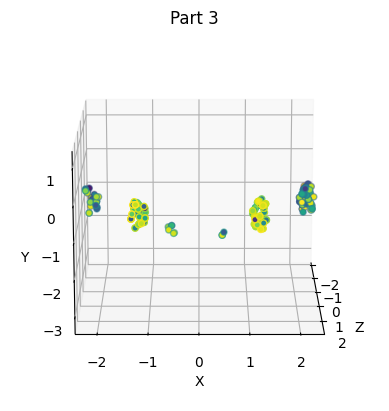

In [75]:
output_sample_parts = output_parts[43, ...].detach().cpu().numpy()
for i in range(4):
    pc_part = pc[output_sample_parts == i]
    fig = visualize_pointcloud(pc_part, f"Part {i}")

In [89]:
output_sample_parts = output_parts[0, ...].detach().cpu().numpy()
for i in range(4):
    pc_part = pc[output_sample_parts == i]
    print(pc_part.shape)

print("--------")

output_sample_parts = output_parts[1, ...].detach().cpu().numpy()
for i in range(4):
    pc_part = pc[output_sample_parts == i]
    print(pc_part.shape)

(829, 3)
(669, 3)
(267, 3)
(283, 3)
--------
(962, 3)
(634, 3)
(195, 3)
(257, 3)


In [79]:
# Let's figure out how we can create patches based on the part segmentation

pc_set = point_set.transpose(1,2)

pc_set.shape, output_parts.shape

(torch.Size([50, 2048, 3]), torch.Size([50, 2048]))

In [84]:
pc_set[output_parts == 1, :].shape

torch.Size([31525, 3])

In [83]:
(output_parts == 1).shape

torch.Size([50, 2048])

In [98]:
# The problem is that each patch has different shapes... Which makes it hard to feed one big
# tensor into the PVCNN since it is flattened and we can't differentiate the patches.

# We go sequentially:
for (input, part_seg) in zip(pc_set, output_parts):
    print(input.shape, part_seg.shape)

    for i in range(num_part):
        # We will feed the patches like that to the refinement PVCNN network.
        print(input[part_seg == i,...].shape)

    break

torch.Size([2048, 3]) torch.Size([2048])
torch.Size([829, 3])
torch.Size([669, 3])
torch.Size([267, 3])
torch.Size([283, 3])


In [99]:
# Let's apply part segmentation on the PVD output

from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Total number of data:400
Min number of points: (train)2048 (test)2048


In [159]:
model.eval()
i = 0
with torch.no_grad():
    for batch in dataloader_pvd:
        input = batch["test_points"].to("cuda").transpose(1,2)
        output_pvd_seg = model(input)
        if i > 1:
            break
        i+=1

In [160]:
output_pvd_seg = output_pvd_seg.transpose(1,2)
output_pvd_seg.shape

torch.Size([20, 2048, 4])

In [161]:
output_parts = output_pvd_seg.data.max(2)[1]
input_pc = input.transpose(1,2).detach().cpu().numpy()
input_pc.shape, output_parts.min(), output_parts.max()

((20, 2048, 3), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'))

In [168]:
INDEX = 1

In [169]:
output_sample_parts = output_parts[INDEX, ...].detach().cpu().numpy()
output_sample_parts.shape, output_sample_parts.min(), output_sample_parts.max()

((2048,), 0, 2)

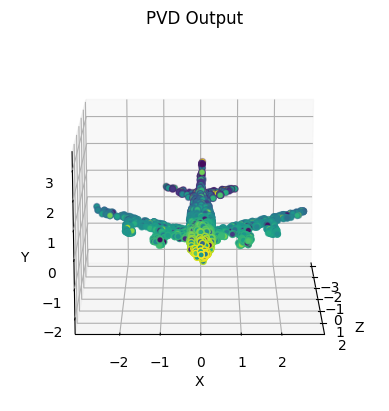

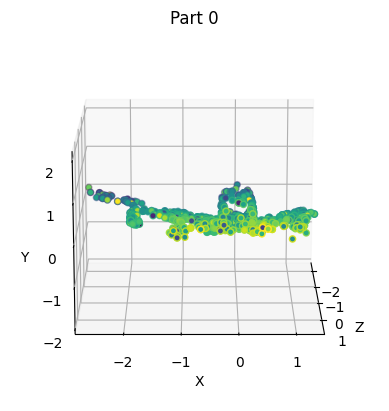

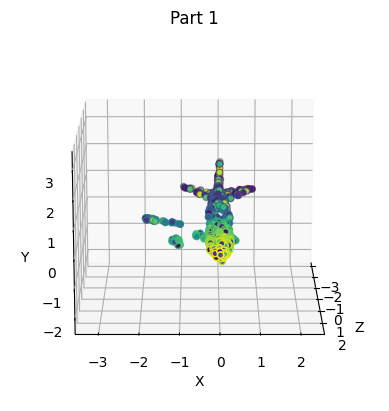

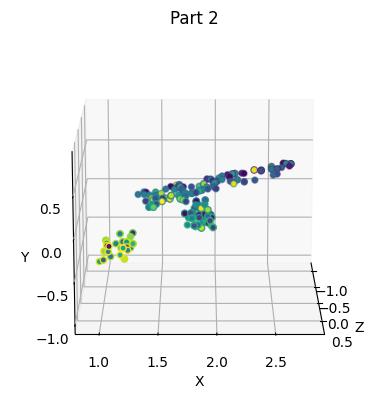

In [170]:
fig = visualize_pointcloud(input_pc[INDEX, ...], "PVD Output")

for i in range(output_sample_parts.max() + 1):
    input_pc_part = input_pc[INDEX, output_sample_parts == i, :]
    fig = visualize_pointcloud(input_pc_part, f"Part {i}")